# DRAFT - Ehancing AeroMAPS modelling --> variable demand and fuels introduction comparision

## 2) Present elasticity results from other ipynb

## 3) Smart optim process
First, no elasticity to get a quick first guess.

- start from minim on carbon budget
- get the optimized results for evry shar of cb between min cb / 3.5 (MMA?)
- Restart from no elast results. Which solver? MMA too slow? 

TODO 30/07 ==> Config file


### Imports and settings

In [ ]:
# Standard library
import warnings
from gemseo.settings.post import BasicHistory_Settings

from typing import Tuple
from copy import deepcopy

# Third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


# GEMSEO and optimisation
import gemseo as gm
from gemseo.algos.design_space import DesignSpace
from gemseo.algos.opt.scipy_local.settings.slsqp import SLSQP_Settings

# from gemseo.algos.opt.nlopt.settings.nlopt_cobyla_settings import NLOPT_COBYLA_Settings
# from gemseo.algos.opt.nlopt.settings.nlopt_mma_settings import NLOPT_MMA_Settings


# GEMSEO extensions
# from gemseo_pymoo.algos.opt._settings.ga_settings import GASettings

# AeroMAPS core
from aeromaps import create_process
from aeromaps.core.models import models_optim_complex
from aeromaps.core.gemseo import CustomDataConverter

# AeroMAPS utilities and base model
from aeromaps.utils.functions import custom_logger_config, create_partitioning, merge_json_files
from aeromaps.models.base import AeroMAPSModel, aeromaps_interpolation_function

# Configure logger
custom_logger_config(gm.configure_logger())

# Optional: enable interactive plotting (Jupyter-specific)
%matplotlib widget

# 1- Scenario initialisation and settings

The first phase corresponds to running a first, central scenario with AeroMAPS. Other runs ar performed afterwards.

In [ ]:
create_partitioning(file="data/aeroscope_europe_data.csv")

In [ ]:
merge_json_files(
    "data/partitioned_inputs.json",
    "data/inputs.json",
    "data/partitioned_inputs_merged.json",
)

In [ ]:
models_optim_complex["models_energy_without_fuel_effect"].pop("dropin_fuel_distribution")


# Custom dropin fuel distribution model for optimisation
class DropinFuelDistribution(AeroMAPSModel):
    def __init__(self, name="dropin_fuel_distribution", *args, **kwargs):
        super().__init__(name, *args, **kwargs)

    def compute(
        self,
        biofuel_share_optim: list,
        electrofuel_share_optim: list,
    ) -> Tuple[pd.Series, pd.Series, pd.Series]:
        """Fuel distribution calculation using interpolation functions"""

        biofuel_share = pd.Series(0.0, index=range(self.historic_start_year, self.end_year + 1))
        electrofuel_share = pd.Series(0.0, index=range(self.historic_start_year, self.end_year + 1))

        biofuel_share[2024] = 0.5
        biofuel_share_reference_years = [2025, 2030, 2035, 2040, 2045, 2050]
        biofuel_share_loc = biofuel_share_optim.copy()
        biofuel_share_loc.insert(0, 2)

        biofuel_share.loc[2025:2050] = aeromaps_interpolation_function(
            self,
            biofuel_share_reference_years,
            biofuel_share_loc,
            method="linear",
            positive_constraint=True,
            model_name=self.name,
        )

        self.df.loc[:, "biofuel_share"] = biofuel_share

        electrofuel_share_reference_years = [2025, 2030, 2035, 2040, 2045, 2050]
        electrofuel_share_loc = electrofuel_share_optim.copy()
        electrofuel_share_loc.insert(0, 0)

        # Electrofuel
        electrofuel_share.loc[2025:2050] = aeromaps_interpolation_function(
            self,
            electrofuel_share_reference_years,
            electrofuel_share_loc,
            method="linear",  # linear for optim
            positive_constraint=True,
            model_name=self.name,
        )

        self.df.loc[:, "electrofuel_share"] = electrofuel_share

        # Kerosene
        kerosene_share = 100 - biofuel_share - electrofuel_share
        self.df.loc[:, "kerosene_share"] = kerosene_share

        return biofuel_share, electrofuel_share, kerosene_share


models = {
    "models_optim_complex": models_optim_complex,
    "dropin_fuel_distribution": DropinFuelDistribution("dropin_fuel_distribution"),
}

Create process as usual, the partitionning is recuperated as specified in the config file.

In [ ]:
process = create_process(
    configuration_file="data/config.json", models=models, use_fleet_model=False
)

## 1-a) Parameters configuration / base scenario 

-- Most Parameters directly set in the inputs.json file

- Air traffic evolution   
We consider an exogenous growth rate, which is the one that would occur considering a technological/fiscal situation frozen in 2019. 
For the purposes of this article, an uniform growth rate of 3% is set. This is significantly lower from industry prospects such as [Airbus GMF: 3.6%](https://www.airbus.com/en/products-services/commercial-aircraft/market/global-market-forecast) or [Boeing CMO: 3.8%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/CMO_2022_Report_FINAL_v02.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach).
It's relatively hard to pick a value as these encompass both technological improvements and energy substaitution, but to an extend to detailled in some. 

- Aircraft fleet  -> See calibration_on_fleet.ipynb. A new aicraft is introduced in every category (short-medium-long range).  
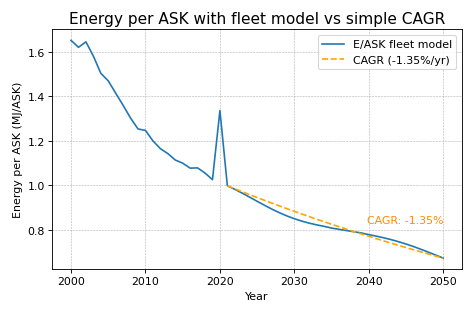  
Mean annual efficiency improvement: 1.35% --> using a simple annual gain model to enhance computation time. 

- Operational improvements  
    Considered via two opportunities.
    - Load factor improvement: improvement to 89% at the end of the scenario. 
    - Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y.   
    
    Cost savings incur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled in AeroMAPS, but not considered in this article due to lack of specific informations to the best of our knowldege.


- Energy  
Instead of using bottom up plant MFSP models, we callibarte these based on the values considered in the MACC article (https://doi.org/10.1016/j.trd.2025.104836)
It enables reducing the coimputation time (Faster optim) but caution as MFSP full computation is more rigorous: large use of e-fuel in the begining influence late MFSP (no-decomissioning hypothesis)

## 1-b) Parameters configuration / specific for optimisation

In [ ]:
### Here as we are operating with a loop, we have to define initial values of an entry point, just as in use_varaible_demand example
process.parameters.price_elasticity = -0.9

process.parameters.airfare_per_rpk = pd.Series(
    0.09251431471704129,
    index=range(process.parameters.historic_start_year, process.parameters.end_year + 1),
)

# Optimisation parameters

process.parameters.biomass_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process.parameters.biomass_availability_constraint_trajectory_reference_years_values = [
    62.8,
    72.1,
    97.8,
    101.8,
]

process.parameters.electricity_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process.parameters.electricity_availability_constraint_trajectory_reference_years_values = [
    102.0456,
    137.5452,
    212.7996,
    276.6168,
]


europe_ask_share = 15.49 / 100

process.parameters.volume_ramp_up_constraint_biofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_biofuel = 0.2  # 20%

process.parameters.volume_ramp_up_constraint_electrofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_electrofuel = 0.2  # 20%

process.parameters.aviation_biomass_allocated_share = 5.0 * europe_ask_share
process.parameters.aviation_electricity_allocated_share = 5.0 * europe_ask_share

process.parameters.aviation_carbon_budget_objective = 2.6 * europe_ask_share

# 2) Optimisation setup

In [ ]:
process.setup()


def optim_setup(process):
    # Create a GEMSEO scenario

    process.gemseo_settings["scenario_type"] = "MDO"
    process.gemseo_settings["formulation"] = "MDF"

    # define the design sapce: electrofuel and biofuel blending mandates

    # NB: possible to modify DropinFuelDistribution to directly fix the first two values instead of creating frozen varaibles here, to reduce the design space size.

    design_space = DesignSpace()
    design_space.add_variable(
        "electrofuel_share_optim",
        size=5,
        lower_bound=[0, 0, 0, 0, 0],
        upper_bound=[100, 100, 100, 100, 100],
        value=[12.81932125, 25.42564173, 37.71881271, 42.95696814, 44.42208359],
    )

    design_space.add_variable(
        "biofuel_share_optim",
        size=5,
        lower_bound=[2, 2, 2, 2, 2],
        upper_bound=[100, 100, 100, 100, 100],
        value=[13.03333997, 26.2372240200, 40.31305862, 40.68022382, 45.68032885],
    )

    process.gemseo_settings["design_space"] = design_space

    # Define the objective
    objective_name = "cumulative_total_surplus_loss_discounted_obj"
    process.gemseo_settings["objective_name"] = objective_name

    process.create_gemseo_scenario()
    # Make optimisation objective values in the 1-10 interval
    process.scenario.formulation.optimization_problem.objective = (
        process.scenario.formulation.optimization_problem.objective * 1e-10
    )

    # Add constraints
    all_constraints = [
        "aviation_carbon_budget_constraint",
        "blend_completeness_constraint",
        "electricity_trajectory_constraint",
        "biomass_trajectory_constraint",
        "electrofuel_use_growth_constraint",
        "biofuel_use_growth_constraint",
        # "biofuel_use_no_degrowth_constraint",
        # "electrofuel_use_no_degrowth_constraint",
    ]

    for constraint in all_constraints:
        process.scenario.add_constraint(constraint, constraint_type="ineq")

    process.scenario.set_differentiation_method("finite_differences")

    # Optim algo: COBYLA, a gradient-free non linear solver ==> Require installation of NLOP; better than SLSQP to start with
    # cobyla_settings = NLOPT_COBYLA_Settings(
    #     max_iter=200,  # CAUTION, 3 set for quick automated test , use something like 200,
    #     ftol_rel=0.001,
    #     ftol_abs=0.001,
    #     # ineq_tolerance=0.015,
    #     normalize_design_space=False,
    #     init_step=2,
    # )

    # pymoo_settings = GASettings(
    #     enable_progress_bar=True,
    #     pop_size=55,
    #     max_iter=1000,
    #     ftol_rel=0.01,
    #     ftol_abs=0.01,
    #     ineq_tolerance=0.01,
    #     normalize_design_space=False,
    #     n_processes=6

    # )

    # mma_settings = NLOPT_MMA_Settings(
    #     max_iter=100,
    #     enable_progress_bar=True,
    #     ftol_abs = 0.01,
    #     # xtol_rel = 1e-50,
    #     normalize_design_space=False,
    # )

    slsqp_settings = SLSQP_Settings(
        max_iter=200,
        enable_progress_bar=True,
        ftol_abs=0.001,
        # xtol_rel = 1e-50,
        normalize_design_space=False,
    )

    process.gemseo_settings["algorithm"] = slsqp_settings

    # Adding design variables to the set of list types varaible (they are declared as ndarray but needed as lists within aeromaps functions)

    CustomDataConverter._list_names.update(process.scenario.get_optim_variable_names())
    return


def optim_setup_min_carb(process):
    # Create a GEMSEO scenario

    process.gemseo_settings["scenario_type"] = "MDO"
    process.gemseo_settings["formulation"] = "MDF"

    # define the design sapce: electrofuel and biofuel blending mandates

    # NB: possible to modify DropinFuelDistribution to directly fix the first two values instead of creating frozen varaibles here, to reduce the design space size.

    design_space = DesignSpace()
    design_space.add_variable(
        "electrofuel_share_optim",
        size=5,
        lower_bound=[0, 0, 0, 0, 0],
        upper_bound=[100, 100, 100, 100, 100],
        value=[9.53566501, 27.03662195, 49.31527213, 52.04227029, 50.01065897],
    )

    design_space.add_variable(
        "biofuel_share_optim",
        size=5,
        lower_bound=[2, 2, 2, 2, 2],
        upper_bound=[100, 100, 100, 100, 100],
        value=[9.53566501, 27.03662195, 50.68472787, 47.95772971, 49.98934103],
    )

    process.gemseo_settings["design_space"] = design_space

    # Define the objective
    objective_name = "aviation_carbon_budget_constraint"
    process.gemseo_settings["objective_name"] = objective_name

    process.create_gemseo_scenario()

    process.scenario.formulation.optimization_problem.objective = (
        process.scenario.formulation.optimization_problem.objective * 10
    )

    # Add constraints
    all_constraints = [
        "blend_completeness_constraint",
        "electricity_trajectory_constraint",
        "biomass_trajectory_constraint",
        "electrofuel_use_growth_constraint",
        "biofuel_use_growth_constraint",
    ]

    for constraint in all_constraints:
        process.scenario.add_constraint(constraint, constraint_type="ineq")

    process.scenario.set_differentiation_method("finite_differences")

    slsqp_settings = SLSQP_Settings(
        max_iter=200,
        enable_progress_bar=True,
        ftol_abs=0.0001,
        # xtol_rel = 1e-50,
        normalize_design_space=False,
    )

    # mma_settings = NLOPT_MMA_Settings(
    #     max_iter=100,
    #     enable_progress_bar=True,
    #     ftol_abs=0.01,
    #     # xtol_rel = 1e-50,
    #     normalize_design_space=False,
    # )

    process.gemseo_settings["algorithm"] = slsqp_settings

    # Adding design variables to the set of list types varaible (they are declared as ndarray but needed as lists within aeromaps functions)

    CustomDataConverter._list_names.update(process.scenario.get_optim_variable_names())
    return


warnings.filterwarnings("ignore")

In [ ]:
process30 = deepcopy(process)
process30.parameters.aviation_carbon_budget_objective = 3.0 * europe_ask_share
process30.setup()
optim_setup(process30)
process30.compute()

In [ ]:
process28 = deepcopy(process)
process28.parameters.aviation_carbon_budget_objective = 2.8 * europe_ask_share
process28.setup()
optim_setup(process28)
process28.compute()

In [ ]:
process26 = deepcopy(process)
process26.parameters.aviation_carbon_budget_objective = 2.6 * europe_ask_share
process26.setup()
optim_setup(process26)
process26.compute()

In [ ]:
# process24 = deepcopy(process)
# process24.parameters.aviation_carbon_budget_objective = 2.4 * europe_ask_share
# process24.setup()
# optim_setup(process24)
# process24.compute()

In [ ]:
# process22 = deepcopy(process)
# process22.parameters.aviation_carbon_budget_objective = 2.2 * europe_ask_share
# process22.setup()
# optim_setup(process22)
# process22.compute()

In [ ]:
# process20 = deepcopy(process)
# process20.parameters.aviation_carbon_budget_objective = 2.0 * europe_ask_share
# process20.setup()
# optim_setup(process20)
# process20.compute()

In [ ]:
process32 = deepcopy(process)
process32.parameters.aviation_carbon_budget_objective = 3.2 * europe_ask_share
process32.setup()
optim_setup(process32)
process32.compute()

In [ ]:
process32.scenario.get_result().design_variable_names_to_values

In [ ]:
process34 = deepcopy(process)
process34.parameters.aviation_carbon_budget_objective = 3.4 * europe_ask_share
process34.setup()
optim_setup(process34)
process34.compute()

In [ ]:
process36 = deepcopy(process)
process36.parameters.aviation_carbon_budget_objective = 3.6 * europe_ask_share
process36.setup()
optim_setup(process36)
process36.compute()

In [ ]:
process38 = deepcopy(process)
process38.parameters.aviation_carbon_budget_objective = 3.8 * europe_ask_share
process38.setup()
optim_setup(process38)
process38.compute()

In [ ]:
process_mincarb = deepcopy(process)
process_mincarb.setup()
optim_setup_min_carb(process_mincarb)
process_mincarb.compute()

In [ ]:
# process20.scenario.save_optimization_history("results/opt_B5_2_0.hdf")
# process22.scenario.save_optimization_history("results/opt_B5_2_2.hdf")
# process24.scenario.save_optimization_history("results/opt_B5_2_4.hdf")
process26.scenario.save_optimization_history("results/opt_B5_2_6.hdf")
process28.scenario.save_optimization_history("results/opt_B5_2_8.hdf")
process30.scenario.save_optimization_history("results/opt_B5_3_0.hdf")
process32.scenario.save_optimization_history("results/opt_B5_3_2.hdf")

In [ ]:
# process20.write_json("results/opt_B5_2_0.json")
# process22.write_json("results/opt_B5_2_2.json")
# process24.write_json("results/opt_B5_2_4.json")
process26.write_json("results/opt_B5_2_6.json")
process28.write_json("results/opt_B5_2_8.json")
process30.write_json("results/opt_B5_3_0.json")
process32.write_json("results/opt_B5_3_2.json")

In [ ]:
process34.scenario.save_optimization_history("results/opt_B5_3_4.hdf")
process36.scenario.save_optimization_history("results/opt_B5_3_6.hdf")
process38.scenario.save_optimization_history("results/opt_B5_3_8.hdf")
process34.write_json("results/opt_B5_3_4.json")
process36.write_json("results/opt_B5_3_6.json")
process38.write_json("results/opt_B5_3_8.json")

In [ ]:
process_mincarb.scenario.save_optimization_history("results/opt_B5_mincarb.hdf")
process_mincarb.write_json("results/opt_B5_mincarb.json")

In [ ]:
process.scenario.post_process(
    post_name="OptHistoryView",
    constraint_names=[
        "aviation_carbon_budget_constraint",
        "blend_completeness_constraint",
        "electricity_trajectory_constraint",
        "biomass_trajectory_constraint",
        "electrofuel_use_growth_constraint",
        "biofuel_use_growth_constraint",
        # "biofuel_use_no_degrowth_constraint",
        # "electrofuel_use_no_degrowth_constraint",
    ],
    save=False,
    show=True,
)

In [ ]:
# noqa: E402

pst = process.scenario.post_process(
    BasicHistory_Settings(
        variable_names=["electrofuel_share_optim", "biofuel_share_optim"],
        save=False,
        show=True,
    )
)

In [ ]:
# Replace this with your actual data
history = pst.database.get_x_vect_history()

n_iter = len(history)
years = np.arange(2020, 2055, 5)

# Create color map normalized over the number of iterations
cmap = plt.get_cmap("viridis")
norm = Normalize(vmin=0, vmax=n_iter - 1)

# Create figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Loop over iterations and plot
for i, arr in enumerate(history):
    color = cmap(norm(i))

    electrofuel = arr[:5]
    biofuel = arr[5:]

    axes[0].plot(np.arange(2030, 2055, 5), electrofuel, color=color, alpha=0.08)
    axes[1].plot(np.arange(2030, 2055, 5), biofuel, color=color, alpha=0.08)

# Plot the last iteration in black dashed line
final_electrofuel = history[-1][:5]
final_biofuel = history[-1][5:]

axes[0].plot(
    np.arange(2030, 2055, 5),
    final_electrofuel,
    color="black",
    linestyle="--",
    linewidth=1,
    label="Final Iteration",
)
axes[1].plot(
    np.arange(2030, 2055, 5),
    final_biofuel,
    color="black",
    linestyle="--",
    linewidth=1,
    label="Final Iteration",
)

# Retrieve the optimal values
res = process.scenario.get_result().design_variable_names_to_values

optimal_electrofuel = res["electrofuel_share_optim"]
optimal_biofuel = res["biofuel_share_optim"]

# Plot the optimal in solid red line
axes[0].plot(
    np.arange(2030, 2055, 5),
    optimal_electrofuel,
    color="red",
    linestyle="-",
    linewidth=2,
    label="Optized Solution",
)
axes[1].plot(
    np.arange(2030, 2055, 5),
    optimal_biofuel,
    color="red",
    linestyle="-",
    linewidth=2,
    label="Optimized Solution",
)

# Labels and titles
axes[0].set_ylabel("Electrofuel Quantity")
axes[0].set_title("Evolution of Electrofuel Over Iterations")
axes[0].grid(True)

axes[1].set_ylabel("Biofuel Quantity")
axes[1].set_title("Evolution of Biofuel Over Iterations")
axes[1].set_xlabel("Year")
axes[1].grid(True)

# Add legends
axes[0].legend()
axes[1].legend()

# Add colorbar to indicate iteration number
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for colorbar
cbar = fig.colorbar(sm, ax=axes, orientation="vertical", label="Iteration")

plt.tight_layout()
plt.show()

## 4) Compare mechanisms
- min cost with ref carbon values
- blend or taxes? maybe 